# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-11-09 02:34:36--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-11-09 02:34:37--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [2]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [3]:
data = pd.read_csv('Gender_bias_spanish.csv')

In [4]:
data

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased
...,...,...
1909,"iba a ir a dash pero mis 3 cortadas, mi color ...",non-biased
1910,que pinche chiste tiene estar medio alto si to...,non-biased
1911,si fuera bien idiota. ya hubiera comprado un a...,non-biased
1912,nota mental: no le quieras ayudar a alguien qu...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

In [5]:
print("Información general del DataFrame:")
print(data.info())
print("\n" + "="*30 + "\n")

print("Conteo de tweets por etiqueta:")
etiquetas_conteo = data['Label'].value_counts()
print(etiquetas_conteo)
print("\n" + "="*30 + "\n")

print("Proporción de tweets por etiqueta (%):")
etiquetas_proporcion = data['Label'].value_counts(normalize=True) * 100
print(etiquetas_proporcion)

Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914 entries, 0 to 1913
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Contents  1914 non-null   object
 1   Label     1914 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB
None


Conteo de tweets por etiqueta:
Label
non-biased    1596
biased         318
Name: count, dtype: int64


Proporción de tweets por etiqueta (%):
Label
non-biased    83.38558
biased        16.61442
Name: proportion, dtype: float64


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

Aproximadamente el 72% de los tweets son 'non-biased' (no sesgados) y el 27% son 'biased' (sesgados).

Si fuéramos a entrenar un modelo de análisis de datos para detectar tweets sesgados, el modelo podría volverse "perezoso" y simplemente adivinar "non-biased" la mayoría de las veces, obteniendo una precisión aparentemente alta pero siendo inútil en la práctica.

En el análisis, significa que hay una muestra más pequeña de palabras y patrones para la categoría "biased".

## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [11]:
def limpiar_texto(texto):
    texto = texto.lower()

    texto = re.sub(r'http\S+', '', texto)

    texto = re.sub(r'@\w+', '', texto)

    texto = re.sub(r'[^a-záéíóúüñ ]', '', texto)

    palabras = texto.split()

    palabras_limpias = [palabra for palabra in palabras if palabra not in stop_words]

    return ' '.join(palabras_limpias)

In [12]:
data['cleaned_text'] = data['Contents'].apply(limpiar_texto)

print("Texto Original vs. Texto Limpio:")
print(data[['Contents', 'cleaned_text']].head())

Texto Original vs. Texto Limpio:
                                            Contents  \
0  @chumeltorres ya cabrón! sin tí se reciben las...   
1  ¿alguien es tan amable de ir a hacerme la comp...   
2  @jenniferduquee hahaha, si está rico, nadamas ...   
3  @evagelcot donde lo ves!!? es mi programa favo...   
4  como siempre mi tortilla triunfa mas que otros...   

                                        cleaned_text  
0  cabrón tí reciben noticias colchoncito puro ch...  
1  alguien tan amable ir hacerme compra mañana ba...  
2          hahaha si rico nadamas falta presentación  
3  ves programa favorito sólo encuentro temporada...  
4          siempre tortilla triunfa mas platos playa  


## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

15 palabras más comunes en 'biased':
[('si', 30), ('mujer', 23), ('mujeres', 19), ('ser', 17), ('así', 16), ('quiero', 14), ('q', 14), ('mejor', 13), ('mamá', 12), ('tan', 12), ('solo', 12), ('cosas', 10), ('niñas', 10), ('casa', 10), ('sé', 9)]


15 palabras más comunes en 'non-biased':
[('si', 167), ('gracias', 90), ('bien', 69), ('año', 65), ('quiero', 62), ('hoy', 62), ('día', 62), ('mejor', 62), ('tan', 59), ('días', 58), ('así', 58), ('ser', 55), ('ver', 55), ('vida', 52), ('pues', 52)]


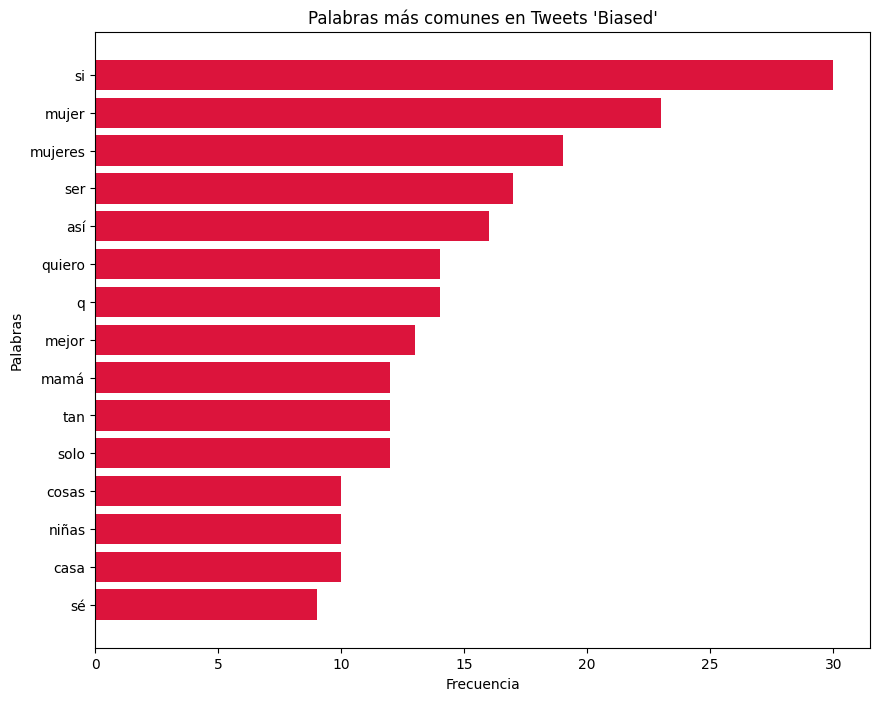

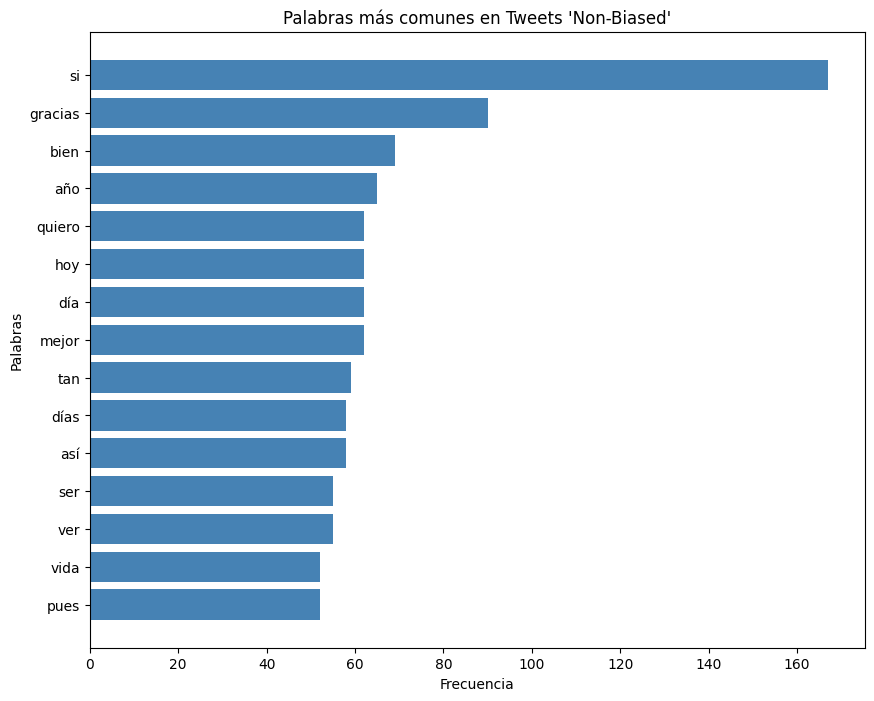

In [13]:
textos_biased = data[data['Label'] == 'biased']['cleaned_text']
textos_non_biased = data[data['Label'] == 'non-biased']['cleaned_text']

palabras_biased = ' '.join(textos_biased).split()
palabras_non_biased = ' '.join(textos_non_biased).split()

conteo_biased = Counter(palabras_biased)
conteo_non_biased = Counter(palabras_non_biased)

print("15 palabras más comunes en 'biased':")
print(conteo_biased.most_common(15))
print("\n" + "="*30 + "\n")
print("15 palabras más comunes en 'non-biased':")
print(conteo_non_biased.most_common(15))


def plot_top_words(counter, title, color):
    top_words = counter.most_common(15)

    palabras = [palabra[0] for palabra in top_words]
    conteos = [palabra[1] for palabra in top_words]

    plt.figure(figsize=(10, 8))
    plt.barh(palabras, conteos, color=color) # Gráfico de barras horizontales
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabras")
    plt.title(title)
    plt.gca().invert_yaxis() # Invertir el eje Y para mostrar la más común arriba
    plt.show()

plot_top_words(conteo_biased, "Palabras más comunes en Tweets 'Biased'", 'crimson')

plot_top_words(conteo_non_biased, "Palabras más comunes en Tweets 'Non-Biased'", 'steelblue')


**Preguntas de Análisis de Frecuencia:**
- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?
- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?
- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?

1.
'Non-biased': Las palabras más comunes son verbos y adjetivos genéricos de la vida cotidiana: "si", "bien", "quiero", son palabras de alta frecuencia pero bajo significado específico.

'Biased': Aquí es donde está la diferencia. aparecen palabras con el género. Palabras como "mujer", "niña", "mama",

2.
En la lista aún no aparecen palabras que sugieran un sesgo, sin embargo hay muchas que son para referirse al género, en especial al género femenino

3.
Una empresa puede crear "listas de alerta" con las palabras más comunes de 'biased' para automáticamente revisar estos comentarios en sus redes sociales o foros para revisión humana.

Pueden monitorear si estas palabras sesgadas se usan junto al nombre de su marca.

Entrenamiento de IA: Pueden usar estas listas para mejorar sus propios chatbots y herramientas de servicio al cliente, asegurándose de que no usen lenguaje sesgado y sepan cómo identificar y manejar a un cliente que está usando ese lenguaje.

## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

In [18]:
def generar_nube_palabras(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stop_words, # Aunque ya limpiamos, no hace daño re-filtrar
                          collocations=False,
                          max_words=100 # Mostrar solo las 100 palabras principales
                         ).generate(texto)

    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # No mostrar ejes (son feos para esto)
    plt.title(titulo, fontsize=20, pad=20)
    plt.show()

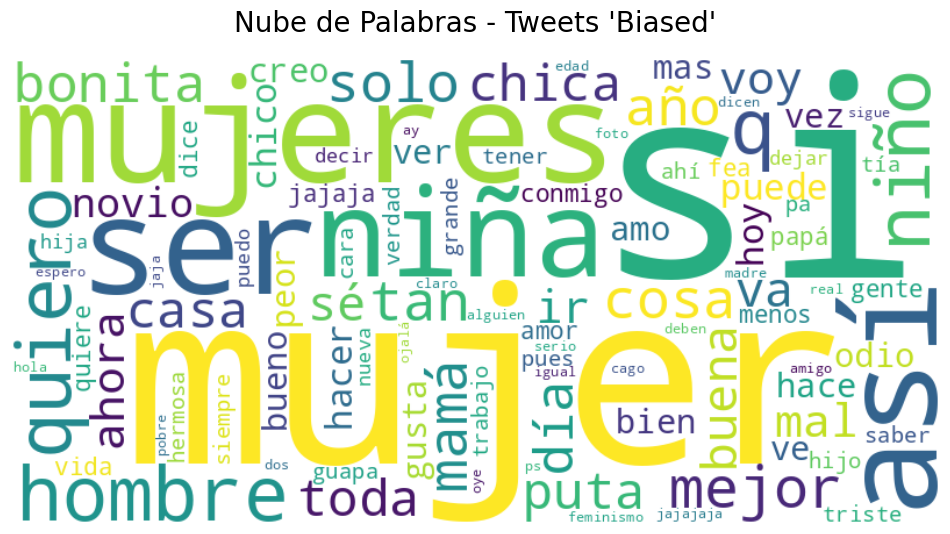

In [19]:
generar_nube_palabras(' '.join(textos_biased), "Nube de Palabras - Tweets 'Biased'")

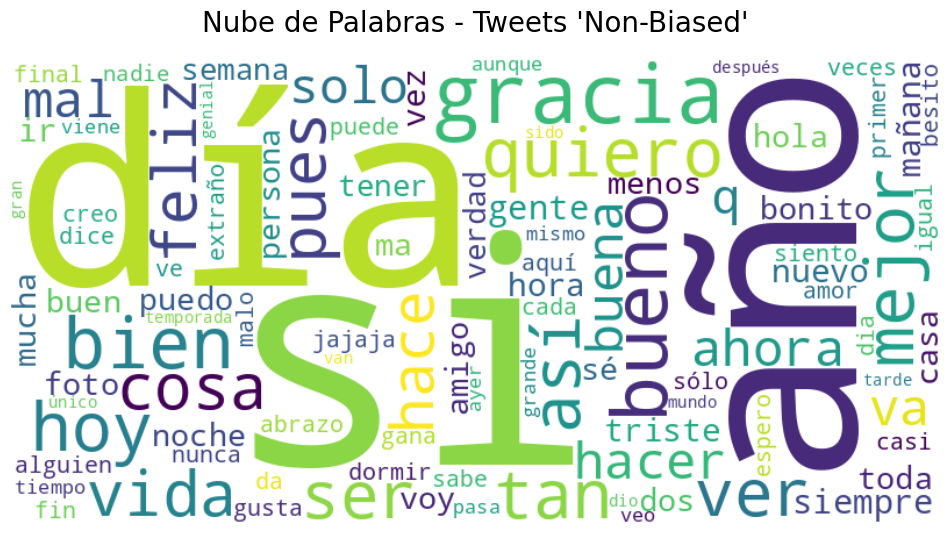

In [20]:
generar_nube_palabras(' '.join(textos_non_biased), "Nube de Palabras - Tweets 'Non-Biased'")

## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:
- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?
- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?
- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?

**Mejorar la Comunicación de la Marca:**

Al identificar palabras y temas que generan sesgo, una marca puede entrenar a sus equipos de marketing y community managers para evitar activamente ese lenguaje y promover una comunicación más inclusiva y positiva.

Pueden monitorear las palabras "biased" más comunes. Si de repente una de esas palabras empieza a usarse mucho en relación con la marca, pueden reaccionar de inmediato, en lugar de enterarse semanas después.

Este análisis justifica la creación de guías de comunicación estrictas que definan qué terminología es aceptable y cuál no, tanto para empleados como para influencers que colaboren con la marca.

*Ajustes en Campaña de Marketing:*

Lo primero es pausar la campaña para detener el daño. Luego, analizar: ¿Es el mensaje? ¿Es el visual? ¿Es el influencer elegido?

Quizás la campaña se está mostrando a un público que reacciona negativamente. Se pueden ajustar los parámetros de la audiencia para excluir a grupos que se identifiquen como generadores de odio o para enfocarse en audiencias más receptivas.

Si el mensaje es ambiguo y se está malinterpretando, se debe clarificar. Si es directamente problemático, se debe retirar y reemplazar por uno que refleje los valores de la marca (por ejemplo, diversidad, respeto).

Preparar respuestas para la comunidad, reconociendo el problema (si fue un error de la marca) y explicando los pasos a seguir.

**Análisis Futuros:**

¿Los tweets sesgados aumentan en ciertos días (ej. Día de la Mujer, 8M)? ¿O después de un evento político o deportivo? Se necesitaría la fecha de los tweets para hacer esto.

El taller identifica "sesgo", pero no "sentimiento" (positivo/negativo). Podríamos aplicar un analizador de sentimiento. ¿Son todos los tweets "biased" negativos?

¿De qué temas se habla dentro de los tweets sesgados? ¿Es principalmente sobre género?

¿Quiénes tuitean esto? ¿Son cuentas aisladas o hay una red de usuarios que se retuitean entre sí para amplificar el mensaje sesgado?